# Neural Network

In [1]:
import numpy as np
import pandas as pd
import re
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
#DB CONNECTION

import psycopg2
from psycopg2 import sql
from psycopg2.extensions import adapt, register_adapter, AsIs
from sqlalchemy import create_engine,text
import getpass
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [ ]:
database = 'f24t03'
user = 'jsmm8'
password = getpass.getpass("Type password and hit enter: ")



Type password and hit enter: ········


In [ ]:
#Create the connection and extract data from 'model_features_data' table
try:
    conn = psycopg2.connect(database=database,
                            user=user,
                            host='pgsql',
                            password=password)
    print("I am able to connect to the database")
except Exception as e:
    print("I am unable to connect to the database:", e)
    raise

# Define the query to select all data from the model_features_data table
query = "SELECT * FROM model_features_data;"

# Use pandas to read the SQL query into a DataFrame
try:
    df = pd.read_sql(query, conn)
    print("Data extracted successfully!")
except Exception as e:
    print("Error extracting data:", e)
finally:
    # Close the connection
    conn.close()


# Display the DataFrame
df.shape

I am able to connect to the database
Data extracted successfully!


(15093, 13)

In [5]:
#Check sample
df.head()

,geo_id,year,median_value,est_total_not_in_labor_force,est_own_occ,est_median_rooms_owner,est_mortgage_debt,median_bedrooms,median_age,weighted_education_score,median_income,pct_owner_occupied,pop_density
0,1500000US290019501001,2020,142300.0,0.383946,435,7.0,0.436782,3.0,36.0,4.76,56313.0,97.10,14.0
1,1500000US290019501001,2021,148100.0,0.379487,411,7.0,0.525547,3.0,40.0,4.82,70972.0,96.25,13.0
2,1500000US290019501001,2022,178900.0,0.363050,405,6.0,0.545679,3.0,39.0,5.08,80208.0,94.85,12.0
3,1500000US290019501002,2020,148300.0,0.343805,453,6.0,0.415011,3.0,39.0,5.11,57167.0,87.79,15.0
4,1500000US290019501002,2021,148800.0,0.377543,482,6.0,0.435685,3.0,31.0,4.86,59125.0,88.28,15.0


In [6]:
#check info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15093 entries, 0 to 15092
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   geo_id                        15093 non-null  object 
 1   year                          15093 non-null  int64  
 2   median_value                  15093 non-null  float64
 3   est_total_not_in_labor_force  15093 non-null  float64
 4   est_own_occ                   15093 non-null  int64  
 5   est_median_rooms_owner        15093 non-null  float64
 6   est_mortgage_debt             15093 non-null  float64
 7   median_bedrooms               15093 non-null  float64
 8   median_age                    15093 non-null  float64
 9   weighted_education_score      15093 non-null  float64
 10  median_income                 15093 non-null  float64
 11  pct_owner_occupied            15093 non-null  float64
 12  pop_density                   15093 non-null  float64
dtypes

In [182]:
#install it for first time
!pip install keras

In [183]:
#install it for first time
!pip install tensorflow

In [184]:
#After installing above packages, import relevant libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LeakyReLU
from tensorflow.keras.initializers import HeNormal, Zeros
from tensorflow.keras.losses import Huber

In [185]:
#2022 model


#Filter and use same logic of removing >1M prices and 0 home values where we dont have any owner occupied homes
X = df[df['year']==2022]
X = X[X['median_value'] != 0]
X = X[X['median_value'] <= 1000000]

y = X['median_value']

#drop unwanted variables
X = X.drop(columns=['geo_id', 'median_value','year']) 


# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Standardize features
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [186]:
#2022 model default learning rate 0.001
model = Sequential()

#Input layer
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))

#Hidden layers 
model.add(Dense(32, activation='leaky_relu'))
model.add(Dense(32, activation='linear'))

#Output layer
model.add(Dense(1, activation='linear'))  # Linear for regression

#Compile the model
model.compile(optimizer='adam', loss=Huber(), metrics=['mae'])


/home/ypd5yb/.local/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [187]:


#Fit model
history = model.fit(X_train, y_train, epochs=300, batch_size=10, validation_split=0.2, verbose=0)


# Predict on the test set
y_pred = model.predict(X_test)

# Compute metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.2f}")


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
MAE: 39752.40
RMSE: 59643.27
R²: 0.74


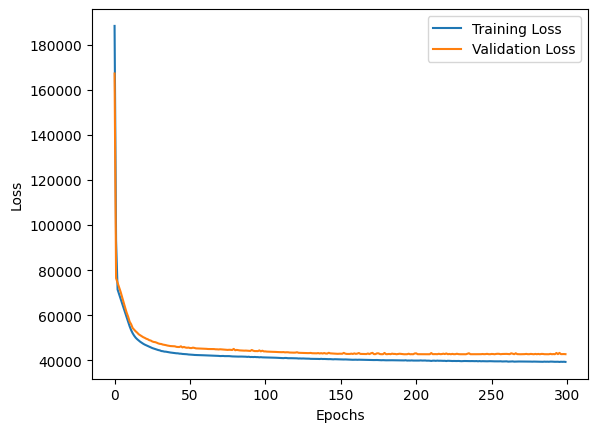

In [188]:
#Plot Training vs Validation Loss

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [189]:
from tensorflow.keras.optimizers import Adam
#2022 model default learning rate 0.002
model = Sequential()

#Input layer
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))

#Hidden layers  
model.add(Dense(32, activation='leaky_relu'))
model.add(Dense(32, activation='linear'))

#Output layer
model.add(Dense(1, activation='linear'))  # Linear for regression

#Compile the model
optimizer = Adam(learning_rate=0.002) 
model.compile(optimizer=optimizer, loss=Huber(), metrics=['mae'])

/home/ypd5yb/.local/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [190]:

#Fit again
history = model.fit(X_train, y_train, epochs=300, batch_size=10, validation_split=0.2, verbose=0)


# Predict on the test set
y_pred = model.predict(X_test)

# Compute metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.2f}")


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
MAE: 39226.82
RMSE: 59192.92
R²: 0.75


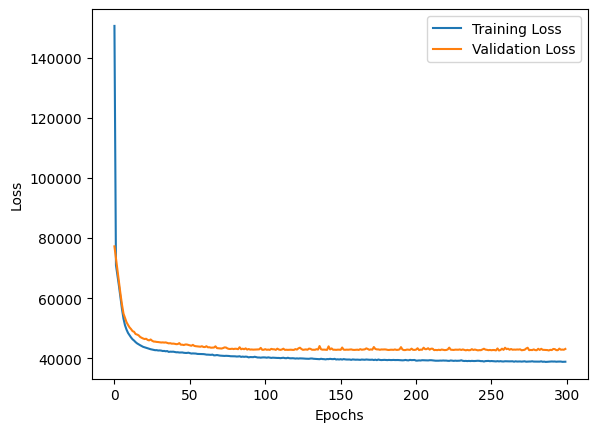

In [191]:
#Plot Training vs Validation Loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [192]:
#2022 model default learning rate 0.0001
model = Sequential()

#Input layer
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))

#Hidden layers  
model.add(Dense(32, activation='leaky_relu'))
model.add(Dense(32, activation='linear'))

#Output layer
model.add(Dense(1, activation='linear'))  # Linear for regression

#Compile the model
optimizer = Adam(learning_rate=0.0001) 
model.compile(optimizer=optimizer, loss=Huber(), metrics=['mae'])

#Fit again
history = model.fit(X_train, y_train, epochs=300, batch_size=10, validation_split=0.2, verbose=0)


# Predict on the test set
y_pred = model.predict(X_test)

# Compute metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.2f}")

/home/ypd5yb/.local/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
MAE: 45176.82
RMSE: 71939.82
R²: 0.63


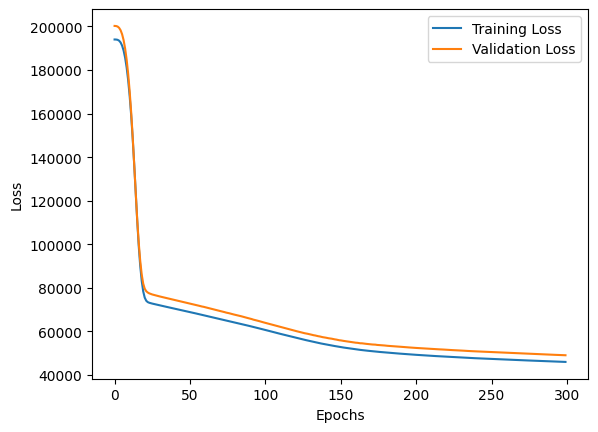

In [193]:
#Plot Training vs Validation Loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

* Default Learning Rate 0.001 and 300 epochs with the architecture we used gave us 0.74% R-squared for 2022 data
* Learning Rate 0.002 and 300 epochs with the architecture we used gave us 0.75% R-squared for 2021 data
* Learning Rate 0.0001 and 300 epochs with the architecture we used gave us 0.63% R-squared for 2020 data

In [194]:
#2021 model 
#Filter and use same logic of removing >1M prices and 0 home values where we dont have any owner occupied homes
X2 = df[df['year']==2021]
X2 = X2[X2['median_value'] != 0]
X2 = X2[X2['median_value'] <= 1000000]
y2 = X2['median_value']
#drop unwanted variables
X2 = X2.drop(columns=['geo_id', 'median_value','year']) 

# Train-test split
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, random_state=0)
#scale and fit
X_train2 = scaler.fit_transform(X_train2)
X_test2 = scaler.transform(X_test2)

In [195]:
#2021 model default learning rate 0.001
model2 = Sequential()

#Input layer
model2.add(Dense(64, input_dim=X_train2.shape[1], activation='relu'))

#Hidden layers  
model2.add(Dense(32, activation='leaky_relu'))
model2.add(Dense(32, activation='linear'))

#Output layer
model2.add(Dense(1, activation='linear'))  # Linear for regression

#Compile the model
model2.compile(optimizer='adam', loss=Huber(), metrics=['mae'])


/home/ypd5yb/.local/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [196]:
#Fit model
history2 = model2.fit(X_train2, y_train2, epochs=300, batch_size=10, validation_split=0.2, verbose=0)

# Predict on the test set
y_pred2 = model2.predict(X_test2)

# Compute metrics
mae2 = mean_absolute_error(y_test2, y_pred2)
rmse2 = np.sqrt(mean_squared_error(y_test2, y_pred2))
r22 = r2_score(y_test2, y_pred2)

print(f"MAE: {mae2:.2f}")
print(f"RMSE: {rmse2:.2f}")
print(f"R²: {r22:.2f}")


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
MAE: 37778.11
RMSE: 64043.82
R²: 0.67


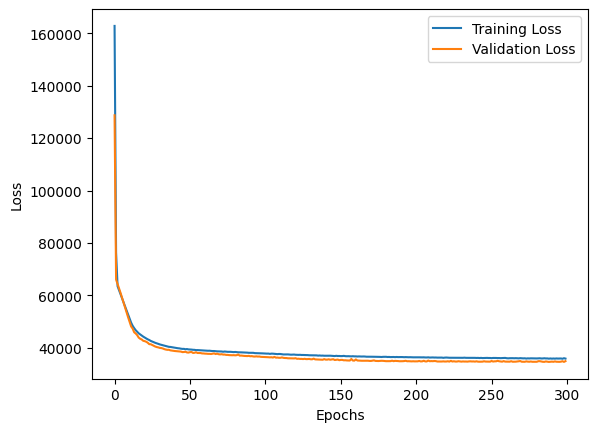

In [197]:
#Plot Training vs Validation Loss
plt.plot(history2.history['loss'], label='Training Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [198]:
#2021 model default learning rate 0.002
model2 = Sequential()

#Input layer
model2.add(Dense(64, input_dim=X_train2.shape[1], activation='relu'))

#Hidden layers 
model2.add(Dense(32, activation='leaky_relu'))
model2.add(Dense(32, activation='linear'))

#Output layer
model2.add(Dense(1, activation='linear'))  # Linear for regression

#Compile the model
optimizer = Adam(learning_rate=0.002) 
model2.compile(optimizer=optimizer, loss=Huber(), metrics=['mae'])

/home/ypd5yb/.local/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [199]:
#Fit again
history2 = model2.fit(X_train2, y_train2, epochs=300, batch_size=10, validation_split=0.2, verbose=0)

# Predict on the test set
y_pred2 = model2.predict(X_test2)

# Compute metrics
mae2 = mean_absolute_error(y_test2, y_pred2)
rmse2 = np.sqrt(mean_squared_error(y_test2, y_pred2))
r22 = r2_score(y_test2, y_pred2)

print(f"MAE: {mae2:.2f}")
print(f"RMSE: {rmse2:.2f}")
print(f"R²: {r22:.2f}")


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
MAE: 36519.01
RMSE: 64094.42
R²: 0.67


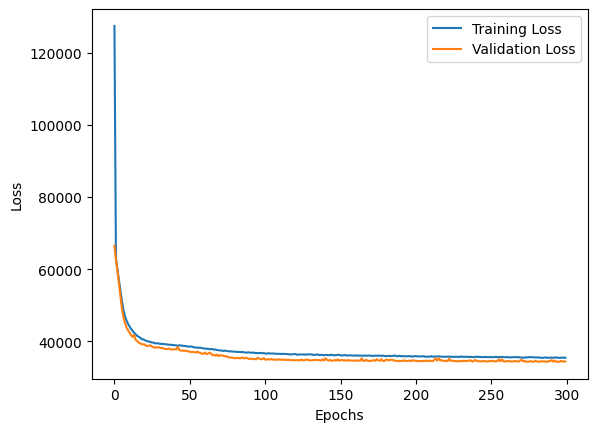

In [200]:
#Plot Training vs Validation Loss
plt.plot(history2.history['loss'], label='Training Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [201]:
#2021 model default learning rate 0.0001
model2 = Sequential()

#Input layer
model2.add(Dense(64, input_dim=X_train2.shape[1], activation='relu'))

#Hidden layers 
model2.add(Dense(32, activation='leaky_relu'))
model2.add(Dense(32, activation='linear'))

#Output layer
model2.add(Dense(1, activation='linear'))  # Linear for regression

#Compile the model
optimizer = Adam(learning_rate=0.0001) 
model2.compile(optimizer=optimizer, loss=Huber(), metrics=['mae'])

#Fit again
history2 = model2.fit(X_train2, y_train2, epochs=300, batch_size=10, validation_split=0.2, verbose=0)

# Predict on the test set
y_pred2 = model2.predict(X_test2)

# Compute metrics
mae2 = mean_absolute_error(y_test2, y_pred2)
rmse2 = np.sqrt(mean_squared_error(y_test2, y_pred2))
r22 = r2_score(y_test2, y_pred2)

print(f"MAE: {mae2:.2f}")
print(f"RMSE: {rmse2:.2f}")
print(f"R²: {r22:.2f}")


/home/ypd5yb/.local/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
MAE: 43332.07
RMSE: 76460.45
R²: 0.53


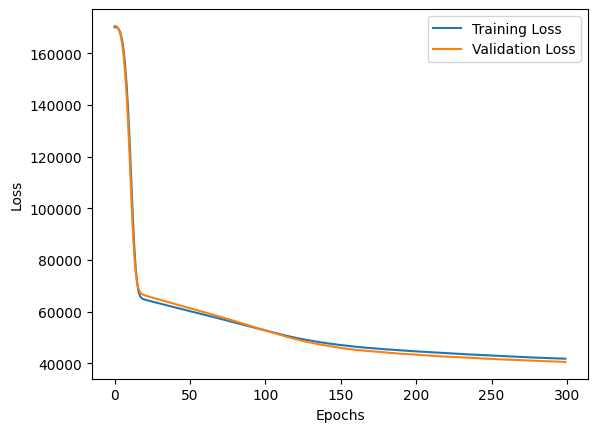

In [202]:
#Plot Training vs Validation Loss
plt.plot(history2.history['loss'], label='Training Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

* Default Learning Rate 0.001 and 300 epochs with the architecture we used gave us  0.67% R-squared for 2022 data
* Learning Rate 0.002 and 300 epochs with the architecture we used gave us  0.67% R-squared for 2021 data
* Learning Rate 0.0001 and 300 epochs with the architecture we used gave us  0.53% R-squared for 2020 data

In [203]:
#2020 model
#Filter and use same logic of removing >1M prices and 0 home values where we dont have any owner occupied homes
X3 = df[df['year']== 2020]
X3 = X3[X3['median_value'] != 0]
X3 = X3[X3['median_value'] <= 1000000]
y3 = X3['median_value']

#drop unwanted variables
X3 = X3.drop(columns=['geo_id', 'median_value','year']) 

# Train-test split
X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y3, test_size=0.2, random_state=0)
#scale and fit
X_train3 = scaler.fit_transform(X_train3)
X_test3 = scaler.transform(X_test3)

In [204]:
#2020 model default learning rate 0.001
model3 = Sequential()

#Input layer
model3.add(Dense(64, input_dim=X_train3.shape[1], activation='relu'))

#Hidden layers 
model3.add(Dense(32, activation='leaky_relu'))
model3.add(Dense(32, activation='linear'))

#Output layer
model3.add(Dense(1, activation='linear'))  # Linear for regression

#Compile the model
model3.compile(optimizer='adam', loss=Huber(), metrics=['mae'])


/home/ypd5yb/.local/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [205]:
#fit model
history3 = model3.fit(X_train3, y_train3, epochs=300, batch_size=10, validation_split=0.2, verbose=0 )

# Predict on the test set
y_pred3 = model3.predict(X_test3)

# Compute metrics
mae3 = mean_absolute_error(y_test3, y_pred3)
rmse3 = np.sqrt(mean_squared_error(y_test3, y_pred3))
r23 = r2_score(y_test3, y_pred3)

print(f"MAE: {mae3:.2f}")
print(f"RMSE: {rmse3:.2f}")
print(f"R²: {r23:.2f}")


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
MAE: 35229.60
RMSE: 57233.93
R²: 0.68


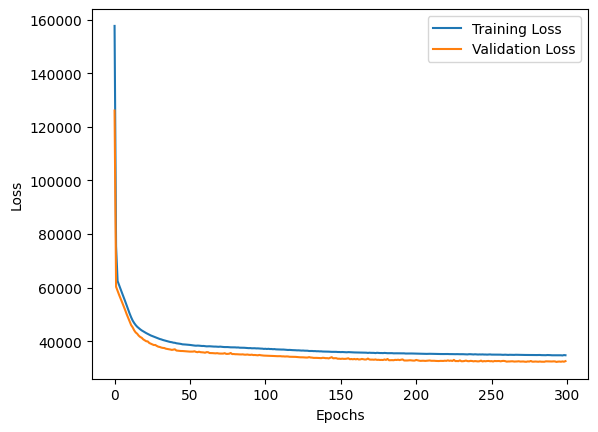

In [206]:
#Plot Training vs Validation Loss
plt.plot(history3.history['loss'], label='Training Loss')
plt.plot(history3.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [207]:
#2020 model default learning rate 0.002
model3 = Sequential()

#Input layer
model3.add(Dense(64, input_dim=X_train3.shape[1], activation='relu'))

#Hidden layers 
model3.add(Dense(32, activation='leaky_relu'))
model3.add(Dense(32, activation='linear'))

#Output layer
model3.add(Dense(1, activation='linear'))  # Linear for regression
optimizer = Adam(learning_rate=0.002) 
#Compile the model
model3.compile(optimizer=optimizer, loss=Huber(), metrics=['mae'])


/home/ypd5yb/.local/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [208]:
#Fit again
history3 = model3.fit(X_train3, y_train3, epochs=300, batch_size=10, validation_split=0.2, verbose=0 )

# Predict on the test set
y_pred3 = model3.predict(X_test3)

# Compute metrics
mae3 = mean_absolute_error(y_test3, y_pred3)
rmse3 = np.sqrt(mean_squared_error(y_test3, y_pred3))
r23 = r2_score(y_test3, y_pred3)

print(f"MAE: {mae3:.2f}")
print(f"RMSE: {rmse3:.2f}")
print(f"R²: {r23:.2f}")


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
MAE: 34946.40
RMSE: 57911.25
R²: 0.68


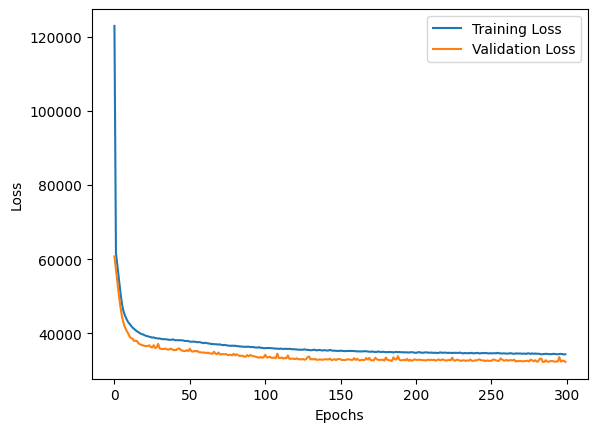

In [209]:
#Plot Training vs Validation Loss
plt.plot(history3.history['loss'], label='Training Loss')
plt.plot(history3.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [210]:
#2020 model default learning rate 0.0001
model3 = Sequential()

#Input layer
model3.add(Dense(64, input_dim=X_train3.shape[1], activation='relu'))

#Hidden layers 
model3.add(Dense(32, activation='leaky_relu'))
model3.add(Dense(32, activation='linear'))

#Output layer
model3.add(Dense(1, activation='linear'))  # Linear for regression
optimizer = Adam(learning_rate=0.0001) 
#Compile the model
model3.compile(optimizer=optimizer, loss=Huber(), metrics=['mae'])

#Fit again
history3 = model3.fit(X_train3, y_train3, epochs=300, batch_size=10, validation_split=0.2, verbose=0 )

# Predict on the test set
y_pred3 = model3.predict(X_test3)

# Compute metrics
mae3 = mean_absolute_error(y_test3, y_pred3)
rmse3 = np.sqrt(mean_squared_error(y_test3, y_pred3))
r23 = r2_score(y_test3, y_pred3)

print(f"MAE: {mae3:.2f}")
print(f"RMSE: {rmse3:.2f}")
print(f"R²: {r23:.2f}")


/home/ypd5yb/.local/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
MAE: 38845.36
RMSE: 68437.96
R²: 0.55


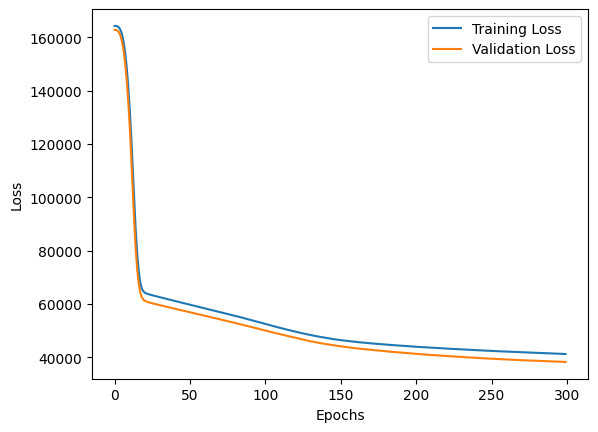

In [211]:
#Plot Training vs Validation Loss
plt.plot(history3.history['loss'], label='Training Loss')
plt.plot(history3.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

* Default 0.001 and 300 epochs with the architecture we used gave us  0.68% R-squared for 2022 data
* Leaning Rate 0.002 and 300 epochs with the architecture we used gave us  0.68% R-squared for 2021 data
* Leaning Rate 0.0001 and 300 epochs with the architecture we used gave us  0.55% R-squared for 2020 data

**Neural Network model with learning rate 0.002 have R-squared ranges for all 3 years around 67 to 75%. This is similar to other models like XGBoost and Random forest but on a lower end of 70% and could not outperform XGBoost performance**